# **ANALYSIS S3 - HSBG - EU**

## **Context**

During Season 3 of *Hearthstone Battlegrounds*, all players who played at least one game were included in the official leaderboard published by Blizzard:  
👉 [Blizzard Leaderboard – Season 3](https://hearthstone.blizzard.com/fr-fr/community/leaderboards/?region=US&leaderboardId=battlegrounds&seasonId=8)

The EU region leaderboard features **628,779 players** with ratings ranging from **1 to 17,527**.

These data were collected using Blizzard’s public API and are available in the `data/` folder.  
⚠️ **Please do not run the extraction scripts**, as the data has already been retrieved and unnecessary API requests could overload Blizzard’s servers.


## **Run the Jupyter Notebook**

You can simply view the results in the notebook below. However, if you want to execute it yourself, you first need to create a virtual environment to install the required Python libraries.  
Use the following commands:

```bash
python -m venv venv
source venv/bin/activate        # On Windows: venv\Scripts\activate
pip install -r requirements.txt
````

If you’ve collected data from another season or region, simply change the `path` variable accordingly.
Currently, for Season 3 on the EU server, the path is:
`path = "data/s3/eu/battlegrounds.csv"`

If you’ve collected data from the NA server, just place the corresponding CSV file in the appropriate directory (or create it if it doesn't exist).

## **DATA LOADING - From scraping file**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path = "data/s3/eu/battlegrounds.csv"

df = pd.read_csv(filepath_or_buffer=path, delimiter=",")
df.head()

,rank,accountid,rating
0,1,LOUDER,17527
1,2,huyagaoshou,17245
2,3,Sevel,16688
3,4,douyumxjf,16054
4,5,wtybill,16034


To avoid including players with very low ratings who are likely inactive, you can set a minimum rating threshold.

In [ ]:
seuil = 1000

filtered_df = df[df['rating'] > seuil].copy()

## **FUNCTIONS & PLOTS**

In [ ]:
def compute_rank_statistics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes descriptive statistics for the 'rating' column:
    mean, median, quartiles, min, and max.
    """
    stats = df['rating'].describe(percentiles=[0.25, 0.5, 0.75])
    result = pd.DataFrame({
        "stat": ["mean", "min", "max", "Q1 (25%)", "median (50%)", "Q3 (75%)"],
        "value": [
            round(stats["mean"], 2),
            int(stats["min"]),
            int(stats["max"]),
            int(stats["25%"]),
            int(stats["50%"]),
            int(stats["75%"]),
        ]
    })
    return result

In [ ]:
def create_rating_bins(df, bin_size=100):
    """
    Groups player ratings into bins of a defined size,
    and adds:
    - 'percentile': percentage of players in each bin,
    - 'cumulative_probability': cumulative percentage up to and including the current bin.
    """
    max_rating = df['rating'].max()
    bins = range(0, max_rating + bin_size, bin_size)

    df['rating_bin'] = pd.cut(
        df['rating'],
        bins=bins,
        right=False,
        labels=[f"{i}-{i + bin_size - 1}" for i in bins[:-1]]
    )
    
    result = df.groupby('rating_bin', observed=False).size().reset_index(name='count')

    total = result['count'].sum()
    result['percentile'] = (result['count'] / total * 100).round(2)
    result['cumulative_probability'] = result['percentile'].cumsum().round(2)

    return result

In [ ]:
def plot_rating_distribution(df):
    """
    Creates visualizations to understand the distribution of player ratings:
    - Histogram
    - Cumulative distribution curve
    Includes vertical reference lines at 6000 and 8000.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Histogram
    axes[0].hist(df['rating'], bins=100, edgecolor='black', alpha=0.7)
    axes[0].set_title('Rating Distribution')
    axes[0].set_xlabel('Rating')
    axes[0].set_ylabel('Number of Players')

    # Vertical lines at 6000 and 8000
    axes[0].axvline(x=6000, color='red', linestyle='--', linewidth=1, label='6000')
    axes[0].axvline(x=8000, color='blue', linestyle='--', linewidth=1, label='8000')
    axes[0].legend()

    # Cumulative curve
    sorted_ratings = np.sort(df['rating'])
    y = np.arange(1, len(sorted_ratings) + 1) / len(sorted_ratings)
    axes[1].plot(sorted_ratings, y)
    axes[1].set_title('Cumulative Distribution')
    axes[1].set_xlabel('Rating')
    axes[1].set_ylabel('Cumulative Proportion')

    # Vertical reference lines on the cumulative plot
    axes[1].axvline(x=6000, color='red', linestyle='--', linewidth=1)
    axes[1].axvline(x=8000, color='blue', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.show()

## **DATA ANALYSIS**

### **Player Distribution**

The first aspect we want to visualize is how players are distributed.  
We will compute key descriptive statistics to better understand this distribution:
- **`Mean`**: the average rating, calculated by summing all ratings and dividing by the number of players.
- **`Median`**: the middle rating that separates the top 50% of players from the bottom 50%.
- **`First Quartile (Q1)`**: the value below which 25% of the players fall.
- **`Third Quartile (Q3)`**: the value below which 75% of the players fall.

These statistics provide a clearer view of the overall distribution and how ratings are spread across the player base.

In [16]:
summary = compute_rank_statistics(df)
summary.head(10)

,stat,value
0,mean,3905.01
1,min,1.00
2,max,17527.00
3,Q1 (25%),1882.00
4,median (50%),4199.00
5,Q3 (75%),6000.00


### **Bin-Based Analysis**

We can now take a closer look at how players are distributed across rating intervals (bins).  
You can adjust the bin size by modifying the `bin_size` variable.

The resulting table contains four columns:
- **`rating_bin`**: the rating interval,
- **`count`**: the number of players within that interval,
- **`percentile`**: the percentage of players in that specific bin,
- **`cumulative_probability`**: the cumulative percentage of players up to and including that bin.

This allows for a more detailed understanding of the distribution across different rating ranges.


In [ ]:
bin_size = 1500

bins = create_rating_bins(df.copy(), bin_size=bin_size)
bins.head(20)

,rating_bin,count,percentile
0,0-1499,277861,21.95
1,1500-2999,167344,13.22
2,3000-4499,227717,17.99
3,4500-5999,267061,21.10
4,6000-7499,297692,23.52
5,7500-8999,25380,2.00
6,9000-10499,2295,0.18
7,10500-11999,396,0.03
8,12000-13499,119,0.01
9,13500-14999,33,0.00


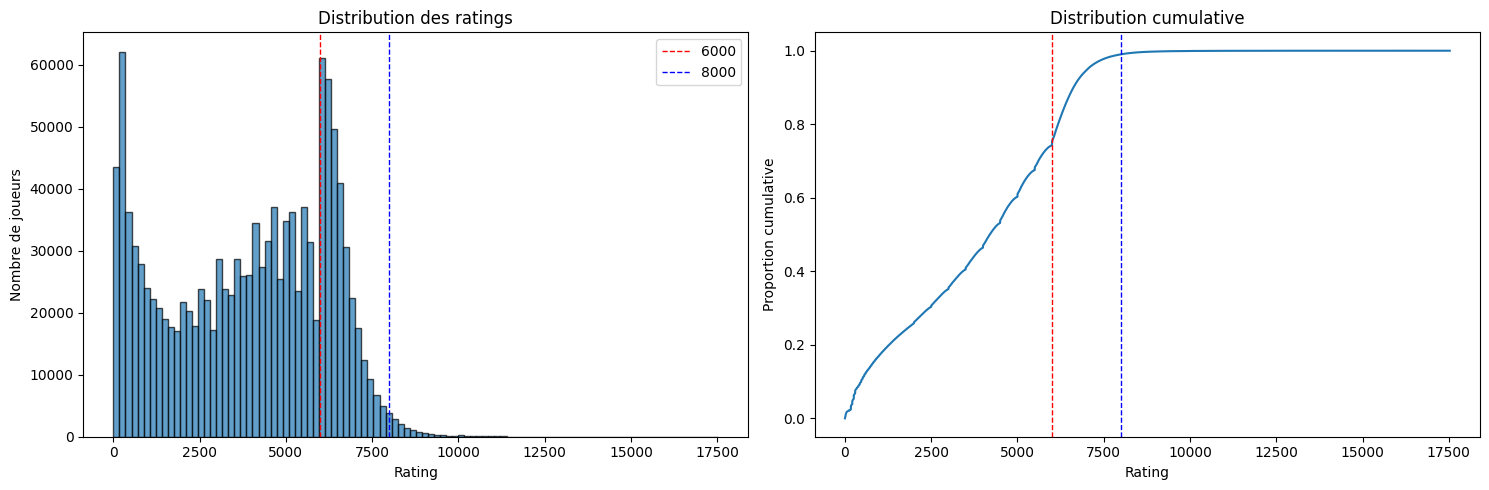

In [18]:
plot_rating_distribution(df)